e07068 contains a very dramatic variable in both NUV and FUV that is not being picked up by the variability search. This is not ok! Probably other variables are being missed. Why is this one being missed?

In [1]:
%matplotlib inline

In [2]:
from gfcat_utils import *

In [3]:
import numpy as np
from astropy.io import fits as pyfits
from astropy import wcs as pywcs
from astropy.visualization import simple_norm, ZScaleInterval
import imageio

In [4]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [16]:
band = 'FUV'
b = band[0].lower()+'d'
eclipse = 7068
e = str(eclipse).zfill(5)
print(f"Processing e{e}...")
tmpdir = "/Users/cm/GFCAT/gfcat/tmp/"
lc_filename = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-{b}-30s-photom-12_8.csv"
fn = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-{b}-full-rice.fits"
fn_mov = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-{b}-30s-rice.fits"
lc = parse_lightcurves(lc_filename)

x = np.array([source['xcenter'] for source in lc])
y = np.array([source['ycenter'] for source in lc])
cps = np.array([np.nanmean(source['cps']) for source in lc])

variables = screen_gfcat([eclipse],band=band,aper_radius=12.8,photdir="/Users/cm/github/gphoton_working/test_data")
print(variables)

image,flagmap,edgemap,wcs,tranges,exptimes=read_image(fn,hdunum=1)
image[np.where(np.isinf(image))]=0 # because it pops out with inf values... IDK

Processing e07068...

  0%|                                                     | 0/1 [00:00<?, ?it/s]

1151

1161

1177

1181

1623

1765

2269

2657

2705

2769

4247

4368

4730

[0 0 0 0 1 2 3 4 5 6 7 8 9]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


{}

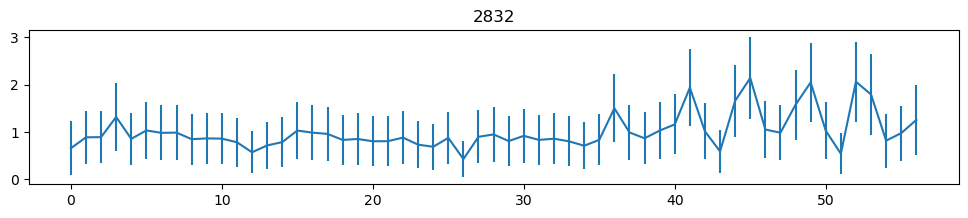

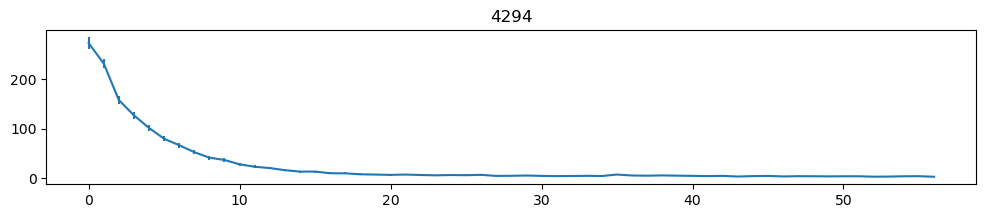

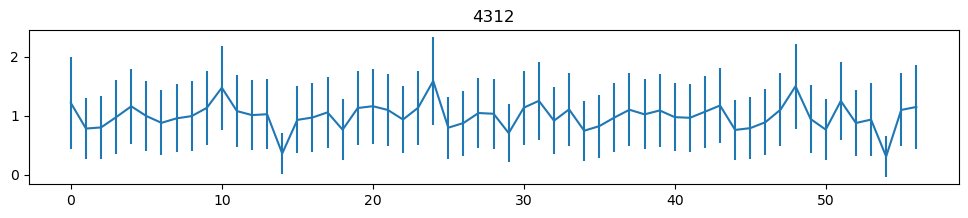

In [6]:
for i in variables[7068]:
    plt.figure(figsize=(12,2));
    t = np.arange(len(lc[i]['cps']))
    plt.title(i)
    plt.errorbar(t,lc[i]['cps'],yerr=3*lc[i]['cps_err']);

In [15]:
pos = []
for i in [4205,4223,4251,4294,4316,4363,4385,4420,4435]:
    pos+=[[lc[i]['xcenter'],lc[i]['ycenter']]]
print(pos)
pos = np.array(pos)
np.sqrt((pos[:,0].max()-pos[:,0].min())**2 + 
        (pos[:,1].max()-pos[:,1].min())**2)

[
    [2473.688362688234, 805.0054569136277],
    [2495.8512092067162, 807.633772938944],
    [2466.2949018340905, 809.3086142748463],
    [2481.09125600596, 814.9341185127178],
    [2459.426517578806, 817.9756853715517],
    [2499.544287004822, 821.8827589636483],
    [2481.5091625809396, 824.5725617329559],
    [2470.2853106962675, 830.03284389606],
    [2488.171049910338, 832.2108655771723]
]

48.472360003092966

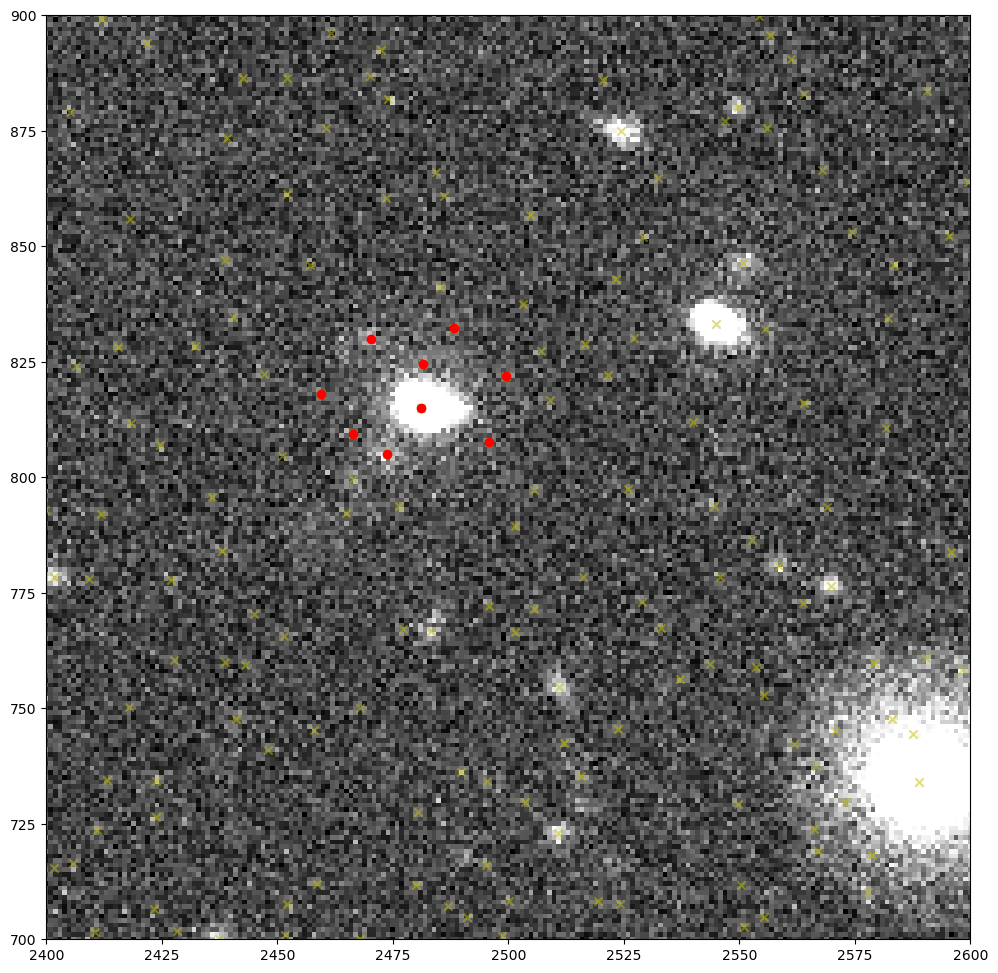

In [6]:
image[np.where(np.isinf(image))]=0 # because it pops out with inf values... IDK
#image[np.where(flagmap)]=0.
x = [source['xcenter'] for source in lc]
y = [source['ycenter'] for source in lc]
plt.figure(figsize=(12,12))
plt.imshow(ZScaleInterval()(image),cmap="Greys_r",origin="lower")
plt.scatter(x,y,c='y',marker='x',alpha=0.5)
plt.xlim([2400,2600])
plt.ylim([700,900])
for i in [2832,4205,4223,4251,4294,4312,4316,4363,4385,4420,4435]:
    plt.plot(lc[i]['xcenter'], lc[i]['ycenter'],'ro')

2481.09125600596 814.3815805940125

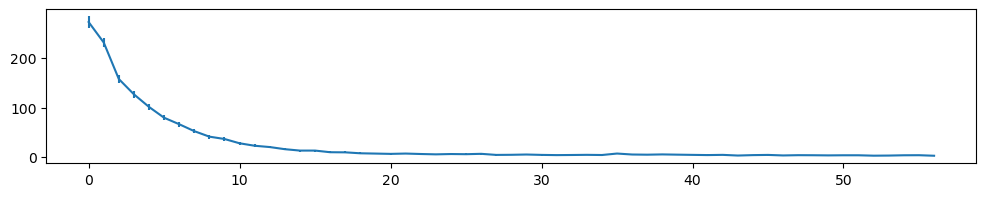

In [8]:
plt.figure(figsize=(12,2))
t = np.arange(len(lc[4294]['cps']))
plt.errorbar(t,lc[4294]['cps'],yerr=3*lc[4294]['cps_err']);
print(lc[4294]['xcenter'],lc[4293]['ycenter'])

In [7]:
#plt.figure(figsize=(13,2))
#for i in range(len(lc)):
#    plt.plot(lc[i]['cps'],'k.-',alpha=0.2)

In [28]:
np.median(lc[4294]['cps'])

5.3614273629612805

In [37]:
expt_fn = lc_filename.split('photom')[0]+'exptime.csv'
expt = parse_exposure_time(expt_fn)


In [43]:
lc = parse_lightcurves(lc_filename)
lc = lc[4294]
expt_fn = lc_filename.split('photom')[0]+'exptime.csv'
expt = parse_exposure_time(expt_fn)

assert any(lc['edge_flags'])==False
assert any(lc['mask_flags'])==False
ix = np.where((lc['cps']!=0) & (np.isfinite(lc['cps'])))[0]
if expt['t1'][ix[-1]] - expt['t0'][ix[0]]<500:
    print("Low expt.")
if len(ix)/(ix[-1]+1-ix[0])<0.75:
    print("Low time on target.")
sort_ix = np.argsort(lc["cps"][ix])
sigma=3
second_min = np.sort((lc['cps']+lc['cps_err']*sigma)[ix])[1]
outlier_ix = np.where((lc['cps'] - lc['cps_err'] * sigma)[ix] > second_min)[0]
if len(outlier_ix) < 3:
    print("Not enough outliers.") # skip if there are not 3 significant outliers using the dumbest heuristic
if is_spiky(lc):
    print("Spiky.")  # skip: multiple spiky peaks, most likely contaminated by an artifact
peak_ix, _ = signal.find_peaks(lc['cps'], prominence=3 * lc['cps_err'], distance=4)
if len(peak_ix):
    if len(peak_ix) > 3:
        print("Peaky.")  # skip multiple spiky peaks, most likely contaminated by an artifact
ad = stats.anderson(lc['cps'][ix])  # standard test of variability
if ad.statistic <= ad.critical_values[2]:
    print("Fails anderson-darling")